In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted

import hvplot.xarray
import hvplot
import cmocean

%load_ext autoreload
%autoreload 3

In [2]:
ds = xr.open_dataset("gs://cmip6/GFDL_CM2_6/control/ocean_3d", engine='zarr', chunks={}, use_cftime=True)
param = xr.open_dataset("gs://cmip6/GFDL_CM2_6/grid", engine='zarr')

In [3]:
import gsw

# Computing Nsquared
The Nsquared interface requires:
* Absolute Salinity, g/kg
* Conservative Temperature (ITS-90), degrees C
* Sea pressure (absolute pressure minus 10.1325 dbar), dbar

The CM2.6 dataset provides:
* Potential temperature, degrees C
* Practical Salinity, psu

In [4]:
SP = ds['salt'] # Practical salinity
PT = ds['temp'] # Potential temperature

In [5]:
# Note that we pass the negative depth because the axis is upward in this function
# The output is almost similar to depth in metres
P = gsw.p_from_z(-param.st_ocean, param.yt_ocean).chunk() # sea pressure ( i.e. absolute pressure - 10.1325 dbar )

In [6]:
Z = param.st_ocean.expand_dims({'yt_ocean': param.yt_ocean})

Text(0, 0.5, 'Sea pressure in dbar')

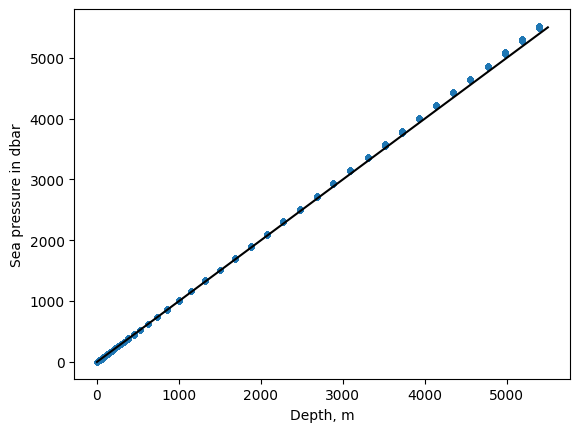

In [13]:
plt.plot(Z.values.ravel(),P.T.values.ravel(), '.');
plt.plot([0,5500],[0,5500],'k')
plt.xlabel('Depth, m')
plt.ylabel('Sea pressure in dbar')

In [7]:
# Note here we provide longitude in a range -280..80, and it is OK. We
# still can target Baltic sea, which is a purpose of this input parameter
# The output is almost similar to Practical Salinity
SA = gsw.SA_from_SP(SP, P, param.xt_ocean, param.yt_ocean) # Absolute Salinity

Text(0, 0.5, 'Absolute Salinity, g/kg')

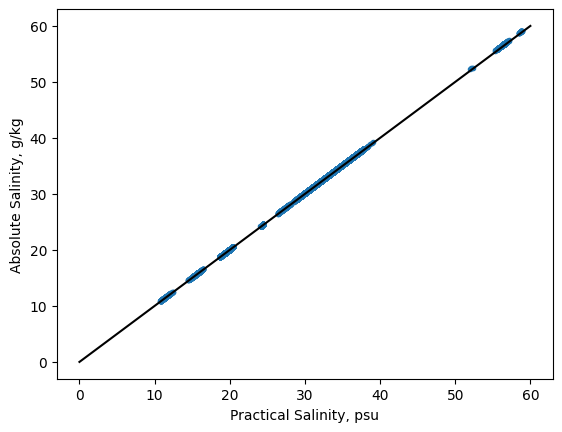

In [18]:
plt.plot(SP[0][10].values.ravel(), SA[0][10].values.ravel(), '.')
plt.plot([0,60], [0,60], 'k')
plt.xlabel('Practical Salinity, psu')
plt.ylabel('Absolute Salinity, g/kg')

In [8]:
# Note the output is almost identical
CT = gsw.CT_from_pt(SA, PT) # Conservative temperature, in degrees

Text(0, 0.5, 'Conservative Temperature, C')

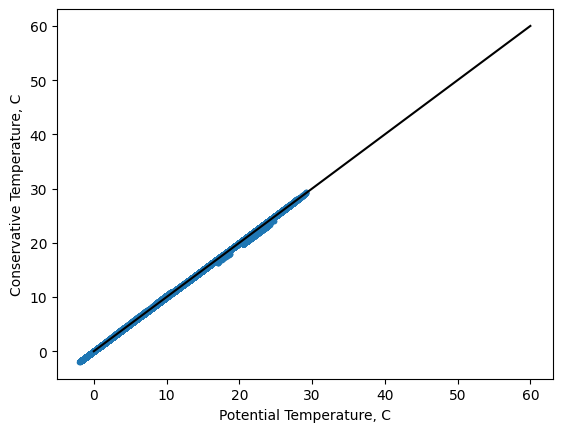

In [22]:
plt.plot(PT[0][10].values.ravel(), CT[0][10].values.ravel(), '.')
plt.plot([0,60], [0,60], 'k')
plt.xlabel('Potential Temperature, C')
plt.ylabel('Conservative Temperature, C')

# Check vertical profile

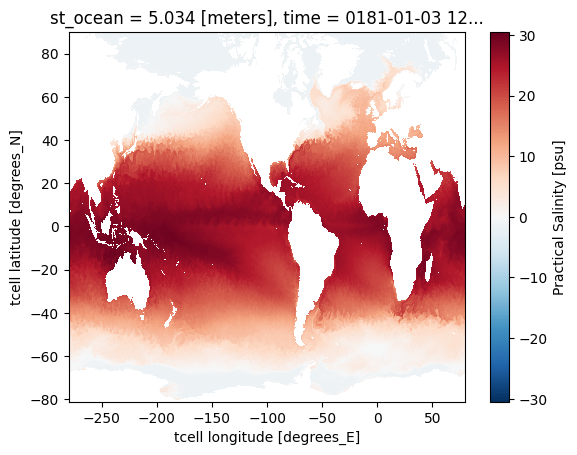

In [48]:
CT[0][0].plot()

In [9]:
def select(x):
    y=x
    if 'xt_ocean' in x.dims:
        y = y.sel(xt_ocean=-149.95, method='nearest')
    if 'yt_ocean' in x.dims:
        y = y.sel(yt_ocean=0.0, method='nearest')

    if 'time' in x.dims:
        y = y.isel(time=0)
    return y

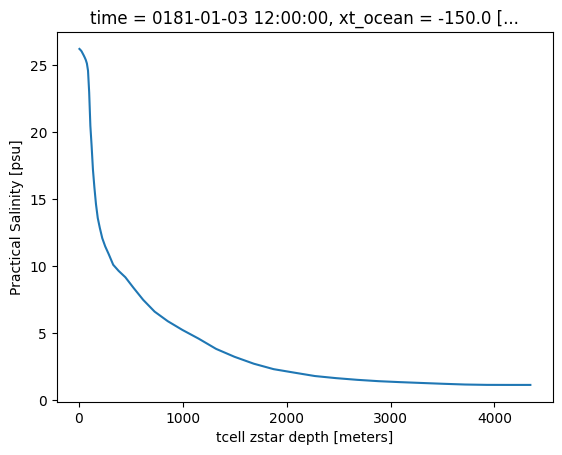

In [10]:
select(CT).plot()

In [11]:
N2 = gsw.Nsquared(select(SA), select(CT), select(P), axis=0)

In [12]:
# So the only vertical coordinate used here is the sea level pressure in dbars
N2_val = gsw.Nsquared(select(SA).values, select(CT).values, select(P).values, axis=0)

In [13]:
(N2_val[0]-N2[0])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan])

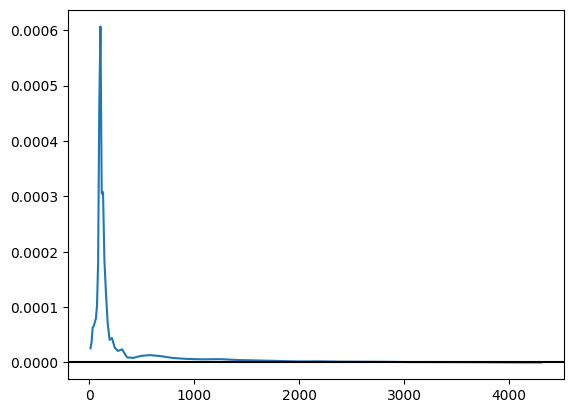

In [14]:
plt.plot(N2[1], N2[0])
plt.axhline(y=0, color='k')

# In-situ density calculated with zero pressure is the potential density

In [15]:
rho = gsw.rho(select(SA), select(CT), select(P))
rho0 = gsw.rho(select(SA), select(CT), 0.)
rho_lazy = gsw.rho(select(SP), select(PT), 0.)
sigma0p = (1000.+gsw.sigma0(select(SA), select(CT)))

In [16]:
(rho0-sigma0p).values

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan])

In [17]:
(rho_lazy-sigma0p).values

array([-0.12197591, -0.12209987, -0.12238848, -0.12296153, -0.12359271,
       -0.12430327, -0.12505459, -0.12591813, -0.12713057, -0.12925056,
       -0.1308847 , -0.13127159, -0.1314391 , -0.13130373, -0.13079422,
       -0.13021478, -0.12995158, -0.12988835, -0.1298882 , -0.12991301,
       -0.13009341, -0.13035144, -0.13074894, -0.13127981, -0.13216479,
       -0.13327509, -0.13442962, -0.13561363, -0.13686913, -0.13821694,
       -0.13949545, -0.14031922, -0.14101364, -0.14156824, -0.14205964,
       -0.14236231, -0.1425869 , -0.14273182, -0.14279102, -0.14280134,
       -0.14277095, -0.14269629, -0.14256094, -0.14240477, -0.14223143,
               nan,         nan,         nan,         nan,         nan])

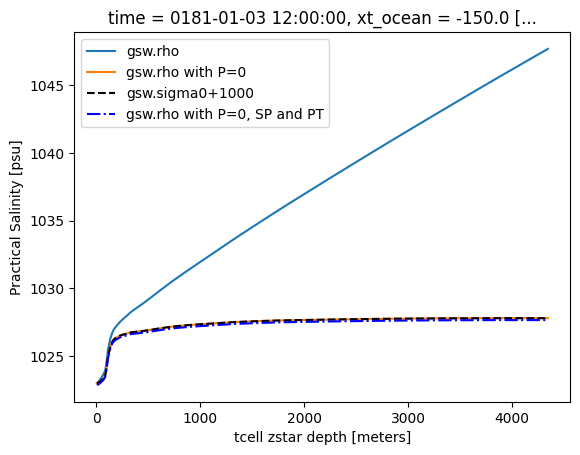

In [18]:
rho.plot(label='gsw.rho')
rho0.plot(label='gsw.rho with P=0')
sigma0p.plot(label='gsw.sigma0+1000', ls='--', color='k')
rho_lazy.plot(label='gsw.rho with P=0, SP and PT', ls='-.', color='b')
plt.legend()

In [19]:
drhodz = rho_lazy.chunk({'st_ocean':-1}).differentiate('st_ocean')
N2_lazy = (9.8*drhodz/1025)

drhodz = rho_lazy.chunk({'st_ocean':-1}).diff('st_ocean') / rho_lazy.st_ocean.diff('st_ocean')
drhodz['st_ocean'] = rho_lazy.st_ocean.rolling(st_ocean=2).mean()[1:]
N2_FD = (9.8*drhodz/1025)

drhodz = sigma0p.chunk({'st_ocean':-1}).diff('st_ocean') / select(P).diff('st_ocean')
drhodz['st_ocean'] = select(P).rolling(st_ocean=2).mean()[1:]
N2_accurate = (9.8*drhodz/1025)

drhodz = sigma0p.chunk({'st_ocean':-1}).diff('st_ocean') / select(P).diff('st_ocean')
drhodz['st_ocean'] = select(P).rolling(st_ocean=2).mean()[1:]
N2_accurate2 = (9.7963*drhodz/1025) # Value of g is from https://www.teos-10.org/pubs/gsw/html/gsw_Nsquared.html

drhodz = sigma0p.chunk({'st_ocean':-1}).diff('st_ocean') / select(P).diff('st_ocean')
drhodz['st_ocean'] = select(P).rolling(st_ocean=2).mean()[1:]
N2_accurate3 = 9.7963*drhodz/sigma0p.rolling(st_ocean=2).mean()[1:].drop_vars('st_ocean')

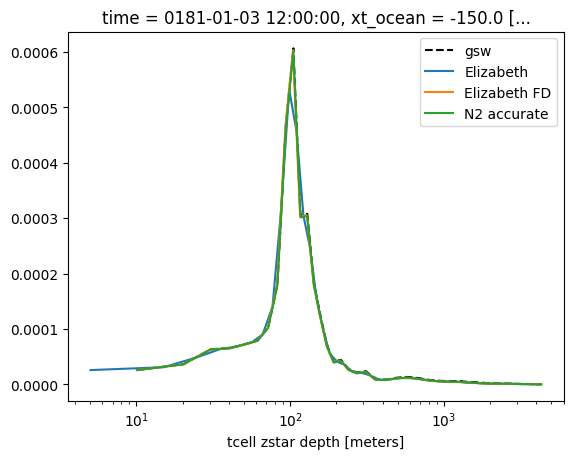

In [20]:
plt.plot(N2[1], N2[0], ls='--', label='gsw', color='k')
N2_lazy.plot(label='Elizabeth')
N2_FD.plot(label='Elizabeth FD')
N2_accurate.plot(label='N2 accurate')
plt.xscale('log')
plt.legend()

In [21]:
np.nanmean((N2[0]-N2_FD.values)**2)

1.3553284829440233e-12

In [22]:
np.nanmean((N2[0]-N2_accurate.values)**2)

2.6983518569707043e-12

In [23]:
np.nanmean((N2[0]-N2_accurate2.values)**2)

2.8529452714523265e-12

In [24]:
np.nanmean((N2[0]-N2_accurate3.values)**2)

2.7975598594687857e-12

## Conclusions of this study on TEOS-10:
* New variables for temperature, salinity and pressure (close to depth) do not change significantly prediction of density
* The most impact is oserved for considering in-situ vs conservative density. sigma0 is the potential density which should be used for N2 computation
* Reference values for g and density used by Elizabeth without conversion of T,S,P are more accurate then any other empirical formulas for N2.

# Including Nsquared computations into CM26 dataset structure

In [25]:
%%time 
ds = DatasetCM26(source='cmip6-3d')

CPU times: user 26.1 s, sys: 9.85 s, total: 35.9 s
Wall time: 25.2 s


In [26]:
# coarse = ds.coarsen()

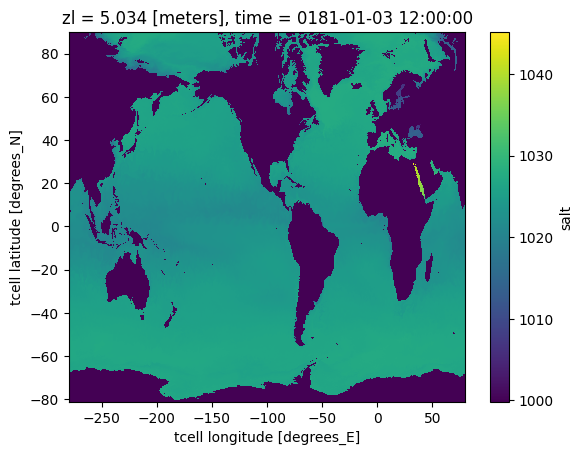

In [27]:
ds.state.rho.isel(time=0,zl=0).plot()

In [28]:
%%time 
test = select(ds.state.Nsquared.rename({'xh': 'xt_ocean', 'yh': 'yt_ocean'})).compute()

CPU times: user 22.6 s, sys: 11.2 s, total: 33.8 s
Wall time: 20.2 s


In [29]:
(test[1:-1].values-N2_FD.values)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., nan, nan, nan, nan, nan])

In [88]:
%time ds.state.baroclinic_speed.isel(time=0).compute();

CPU times: user 27.3 s, sys: 16 s, total: 43.3 s
Wall time: 28 s


In [30]:
%time Rd = ds.state.deformation_radius.isel(time=0).compute()

CPU times: user 26.1 s, sys: 22 s, total: 48.1 s
Wall time: 34.5 s


Text(0.5, 1.0, 'Rossby deformation radius in km')

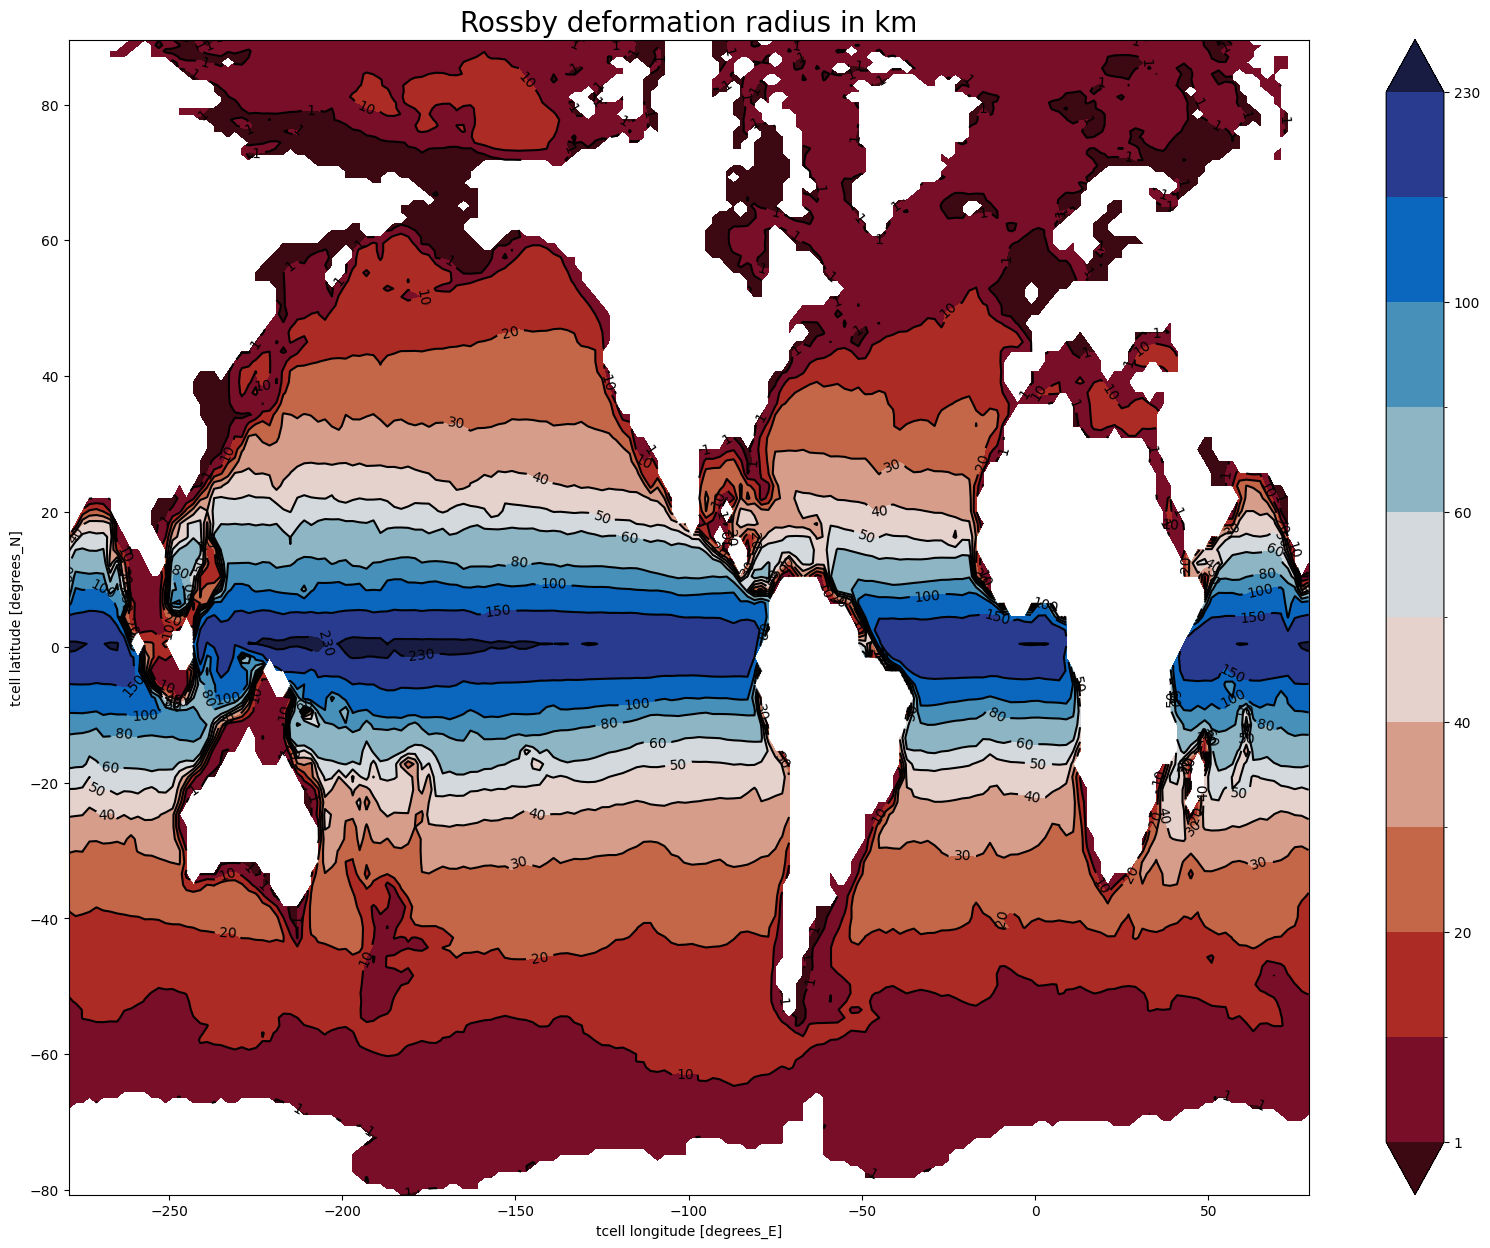

In [83]:
plt.figure(figsize=(20,15))
import cmocean
mask = ds.param.wet[0]
mask = np.where(mask,1,np.nan)

Rdc = (Rd*1e-3*mask).coarsen({'xh':20, 'yh':20}).mean()

(Rdc).plot.contourf(levels=[1,10, 20, 30, 40, 50, 60, 80, 100, 150, 230], cmap=cmocean.cm.balance.reversed(),extend='both')
CS = (Rdc).plot.contour(levels=[1,10, 20, 30, 40, 50, 60, 80, 100, 150, 230], colors='k')
plt.clabel(CS)
plt.title('Rossby deformation radius in km', fontsize=20)

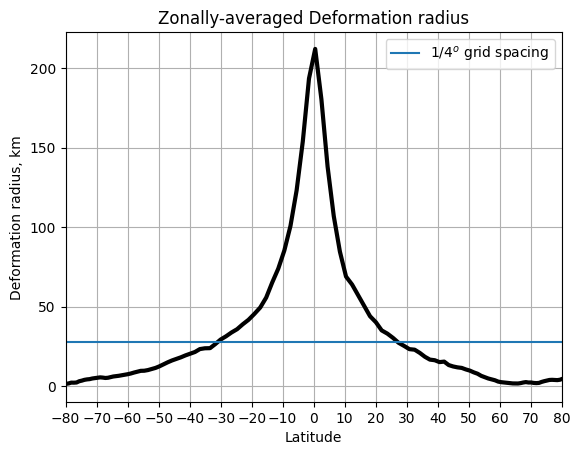

In [84]:
Rdc.mean('xh').plot(color='k', lw=3)
plt.ylabel('Deformation radius, km')
plt.xlabel('Latitude')
plt.title('Zonally-averaged Deformation radius')
plt.xticks(np.arange(-80,100,10));
plt.xlim([-80, 80])
dx = 40000/360/4 # of 1/4 degree model
plt.axhline(y=dx, color='tab:blue', label='$1/4^o$ grid spacing')
plt.grid()
plt.legend()